In [ ]:
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, CRS
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver  # For an exact (classical) minimum eigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer  # Qiskit's wrapper to use eigensolvers with optimization problems

num_assets = 10 # set number of assets (= number of qubits)

In [ ]:
from pyqubo import Binary
import numpy as np
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal

# Generate data

In [3]:

np.random.seed(42)
n_properties = 10
budget = 3

# Step 1: Set a known optimal bitstring (with exactly `budget` ones)
X_opt = np.zeros(n_properties)
X_opt[[1, 4, 7]] = 1  # you choose these positions
X_opt = X_opt.astype(int)

# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Boost the premiums of the "true" optimal ones
mu[X_opt == 1] += 0.2  # make them significantly more attractive

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Now, add stronger correlation between non-optimal properties to make them riskier
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3  # make non-selected more correlated

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)

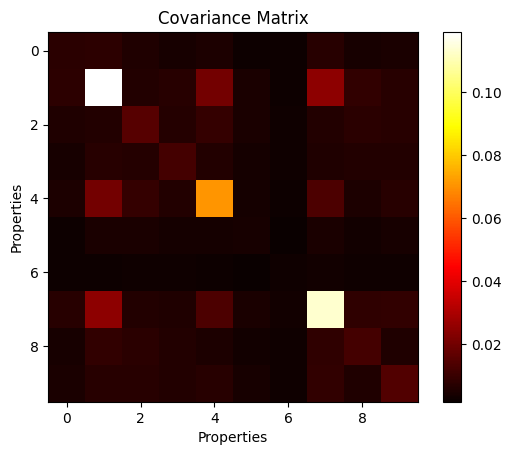

In [4]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

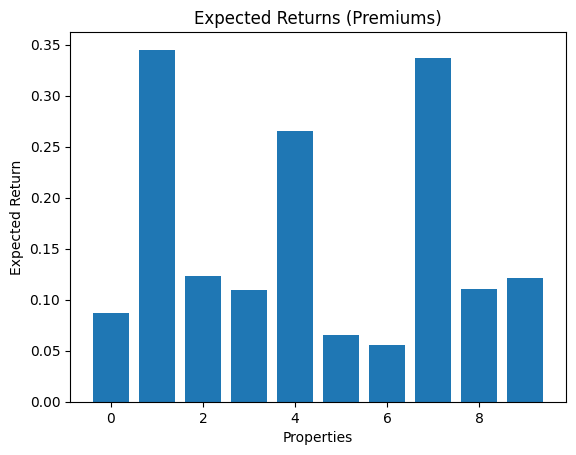

In [5]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

# try 1


In [6]:
# Parameters
from pyqubo import Binary

q = 0.05
lambda_val = 30
n =10  # Number of properties
B = 3

x = [Binary(f'x_{i}') for i in range(n)]
risk_term = 0
for i in range(n):
    for j in range(n):
        risk_term += q * sigma[i, j] * x[i] * x[j]

risk_term = risk_term * q

reward = 0
for i in range(n):
    reward -= mu[i] * x[i]

penatly = 0
for i in range(n):
    penatly += x[i] 

penalty = lambda_val * (penatly - B)**2

H = reward - risk_term + penalty



model = H.compile()

qubo, offset = model.to_qubo()

from qiskit_optimization import QuadraticProgram
qp = QuadraticProgram()

# Add binary variables (Assuming our variables are named 'x_0', 'x_1', ... 'x_9')
for i in range(n):
    qp.binary_var(name=f'x_{i}')

# Prepare dictionaries for the linear and quadratic terms
linear = {}
quadratic = {}
for key, coeff in qubo.items():
    if len(key) == 1:
        var_name = key[0]  # e.g., 'x_0'
        linear[var_name] = coeff
    elif len(key) == 2:
        var1, var2 = key  # e.g., 'x_0', 'x_1'
        quadratic[(var1, var2)] = coeff

qp.minimize(linear=linear, quadratic=quadratic)

# Now, printing qp should show the variables and the objective
print(qp)



minimize -150.08747313239522*x_0^2 + 59.999961043935535*x_0*x_1 + 59.99997069402229*x_0*x_2 + 59.99997917719783*x_0*x_3 + 59.99997501358428*x_0*x_4 + 59.999986885131364*x_0*x_5 + 59.999987611683544*x_0*x_6 + 59.99996485242112*x_0*x_7 + 59.999978085038165*x_0*x_8 + 59.99997716538588*x_0*x_9 - 150.3453691163716*x_1^2 + 59.99996890908021*x_1*x_2 + 59.99996471307582*x_1*x_3 + 59.999897753329414*x_1*x_4 + 59.99997672373932*x_1*x_5 + 59.999986534998015*x_1*x_6 + 59.99987585518469*x_1*x_7 + 59.99995619669939*x_1*x_8 + 59.999964923178275*x_1*x_9 - 150.12323733940795*x_2^2 + 59.99996627468129*x_2*x_3 + 59.99995246916848*x_2*x_4 + 59.99997722086582*x_2*x_5 + 59.99998518270905*x_2*x_6 + 59.99997037782232*x_2*x_7 + 59.99996306734018*x_2*x_8 + 59.99996461841952*x_2*x_9 - 150.10989602468132*x_3^2 + 59.999968578250794*x_3*x_4 + 59.99998191269036*x_3*x_5 + 59.99998428154277*x_3*x_6 + 59.999970716547296*x_3*x_7 + 59.999969103077355*x_3*x_8 + 59.99996885304177*x_3*x_9 - 150.2657782249197*x_4^2 + 59.9999

In [7]:
print(x[4])
print(risk_term)
print(mu)

Binary('x_4')
((((0.000730 * Binary('x_9')) * Binary('x_9')) + ((0.000288 * Binary('x_9')) * Binary('x_8')) + ((0.000453 * Binary('x_9')) * Binary('x_7')) + ((0.000153 * Binary('x_9')) * Binary('x_6')) + ((0.000207 * Binary('x_9')) * Binary('x_5')) + ((0.000358 * Binary('x_9')) * Binary('x_4')) + ((0.000311 * Binary('x_9')) * Binary('x_3')) + ((0.000354 * Binary('x_9')) * Binary('x_2')) + ((0.000351 * Binary('x_9')) * Binary('x_1')) + ((0.000228 * Binary('x_9')) * Binary('x_0')) + ((0.000288 * Binary('x_8')) * Binary('x_9')) + ((0.000606 * Binary('x_8')) * Binary('x_8')) + ((0.000429 * Binary('x_8')) * Binary('x_7')) + ((0.000150 * Binary('x_8')) * Binary('x_6')) + ((0.000165 * Binary('x_8')) * Binary('x_5')) + ((0.000266 * Binary('x_8')) * Binary('x_4')) + ((0.000309 * Binary('x_8')) * Binary('x_3')) + ((0.000369 * Binary('x_8')) * Binary('x_2')) + ((0.000438 * Binary('x_8')) * Binary('x_1')) + ((0.000219 * Binary('x_8')) * Binary('x_0')) + ((0.000453 * Binary('x_7')) * Binary('x_9'))

In [8]:
print(qp.prettyprint())

Problem name: 

Minimize
  -150.08747313239522*x_0^2 + 59.999961043935535*x_0*x_1
  + 59.99997069402229*x_0*x_2 + 59.99997917719783*x_0*x_3
  + 59.99997501358428*x_0*x_4 + 59.999986885131364*x_0*x_5
  + 59.999987611683544*x_0*x_6 + 59.99996485242112*x_0*x_7
  + 59.999978085038165*x_0*x_8 + 59.99997716538588*x_0*x_9
  - 150.3453691163716*x_1^2 + 59.99996890908021*x_1*x_2
  + 59.99996471307582*x_1*x_3 + 59.999897753329414*x_1*x_4
  + 59.99997672373932*x_1*x_5 + 59.999986534998015*x_1*x_6
  + 59.99987585518469*x_1*x_7 + 59.99995619669939*x_1*x_8
  + 59.999964923178275*x_1*x_9 - 150.12323733940795*x_2^2
  + 59.99996627468129*x_2*x_3 + 59.99995246916848*x_2*x_4
  + 59.99997722086582*x_2*x_5 + 59.99998518270905*x_2*x_6
  + 59.99997037782232*x_2*x_7 + 59.99996306734018*x_2*x_8
  + 59.99996461841952*x_2*x_9 - 150.10989602468132*x_3^2
  + 59.999968578250794*x_3*x_4 + 59.99998191269036*x_3*x_5
  + 59.99998428154277*x_3*x_6 + 59.999970716547296*x_3*x_7
  + 59.999969103077355*x_3*x_8 + 59.99996885

In [9]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        # Use global mu, sigma, q, gamma, lambda_val, B
        reward = -np.sum(mu * x)
        risk = q * np.sum(x[:, None] * x[None, :] * sigma)
        penalty = lambda_val * (np.sum(x) - B) ** 2
        value = reward + risk + penalty
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [12]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="pairwise")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

NameError: name 'algorithm_globals' is not defined

In [10]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.], value -270.9483

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 0 0 1 0 0]	-0.9263		1.0000


In [ ]:
def print_result(result, qp):
    """
    Print final and intermediate results
    """

    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


def get_result_numpy(qp, penalty=None):
    """
    Get the result using the exact, classical eigensolver NumPyMinimumEigensolver.
    Return: MinimumEigenOptimizationResult
    """

    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes, penalty=penalty)
    result = exact_eigensolver.solve(qp)

    return result

# Configure a fully parameterized TwoLocal ansatz

def get_result_SamplingVQE(
        qp,
        ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=['rx', 'y'], entanglement='linear', reps=2),
        optimizer=COBYLA(),
        sampler=Sampler(),
        penalty=None
):
    """
    Get the result using as model SamplingVQE(sampler, ansatz, optimizer).
    Return: MinimumEigenOptimizationResult
    """

    # List to store the cost history
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)

    svqe_mes = SamplingVQE(ansatz=ansatz, optimizer=optimizer,
                           sampler=sampler, callback=store_cost)
    svqe = MinimumEigenOptimizer(svqe_mes, penalty=penalty)
    result = svqe.solve(qp)

    return result, cost_history_dict


def get_result_QAOA(
    qp,
    optimizer=COBYLA(),
    reps = 1
):
    
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)


    qaoa_mes = QAOA(sampler = Sampler(), optimizer=optimizer, reps=reps, callback= store_cost)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    return result, cost_history_dict


def get_result_wrapper(result_function, **kwargs):
    """
    Wrapper function to call either get_result_QAOA or get_result_SamplingVQE
    with the provided keyword arguments.
    
    Parameters:
    - result_function: The function to call (get_result_QAOA or get_result_SamplingVQE)
    - kwargs: The keyword arguments to pass to the function
    
    Returns:
    - result: The result from the called function
    - cost_history_dict: The cost history dictionary from the called function
    """

    result, cost_history_dict = result_function(**kwargs)
    
    return result, cost_history_dict


def plot_result_histogram(result, threshold=0):
    """
    Plot the histogram of the valid samples.
    """
    
    # Filter the samples with OptimizationResultStatus.SUCCESS and value below threshold
    valid_samples = []
    for s in result.samples:
        if s.status == OptimizationResultStatus.SUCCESS and s.probability > threshold:
            valid_samples.append(s)

    # Create samples dictionary
    samples_for_plot = {
        " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
        for s in valid_samples
    }

    # Plot histogram
    fig = plot_histogram(samples_for_plot)
    return fig


def plot_cost_history(cost_history_dict, reference=None):
    """
    Plot the cost history.
    """

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(cost_history_dict["cost"], lw=2, marker="o")
    if reference is not None:
        ax.axhline(reference, color="red", ls="--")
    ax.set_ylabel("Cost", fontsize=14)
    ax.set_xlabel("Evaluation count", fontsize=14)
    ax.set_title("Cost history", fontsize=14)
    
    return fig

def prob_exact(result_svqe, result_exact):
    """"
    Find the probability of the exact optimal solution in the SamplingVQE result.
    """
    exact_x = result_exact.x
    prob_vqe = 0
    for sample in result_svqe.samples:
        if sample.x.all() == exact_x.all():
            prob_vqe = sample.probability
            break

    return prob_vqe

/var/folders/4m/ybdr7r2j2_nbh1ytdjdqr5v00000gn/T/ipykernel_65542/2415085015.py:45: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),


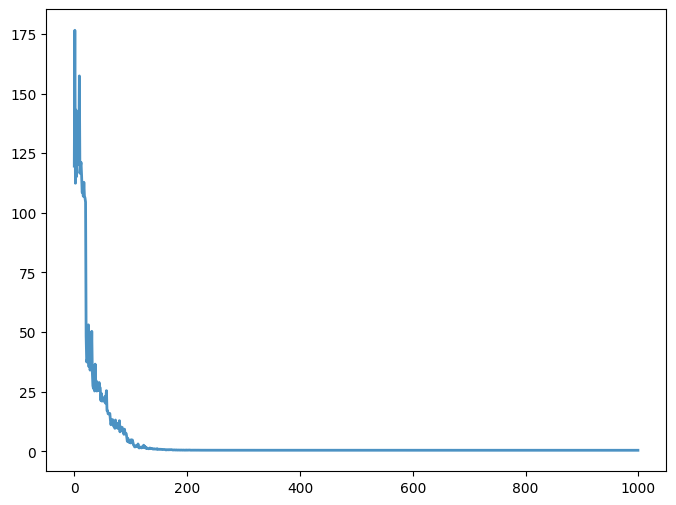

In [ ]:
# Parameters

rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"
reps = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

reference_fval = np.array([])
prob_vqe_exact = []
error_vqe_cost = []
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = np.append(reference_fval, result_exact.fval)

# SamplingVQE result
# ansatz = EfficientSU2(num_qubits=q, reps=reps, su2_gates=su2_gates, entanglement=entanglement)
ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, 
                    entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

# Function values and probabilities
fvals = np.array([s.fval for s in result_svqe.samples])
probabilities = np.array([s.probability for s in result_svqe.samples])

prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)


ax.plot(history["cost"] - reference_cost, lw=2, alpha=0.8, label=f"{q}")